In [1]:
!pip install transformers datasets evaluate rouge-score bert-score sacrebleu sentencepiece
!pip install torch
!pip install pandas numpy matplotlib seaborn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 3.7 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=4d04378c61ef1a2d4668c66ff936f83bbf708d48cd6b7e6153e4a1774a5dc438
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')

from transformers import pipeline
import torch

print("✅ All libraries imported!")
print(f"🔥 CUDA Available: {torch.cuda.is_available()}")

✅ All libraries imported!
🔥 CUDA Available: False


In [3]:
def topsis(data, weights, impacts):
    """
    TOPSIS Method for ranking
    data: DataFrame with models as rows and criteria as columns
    weights: list of weights for each criterion
    impacts: list of '+' or '-' for each criterion (+ means higher is better)
    """
    # Step 1: Normalize the data
    norm_data = data / np.sqrt((data**2).sum())

    # Step 2: Apply weights
    weighted_data = norm_data * weights

    # Step 3: Find ideal best and ideal worst
    ideal_best = []
    ideal_worst = []

    for i, impact in enumerate(impacts):
        if impact == '+':
            ideal_best.append(weighted_data.iloc[:, i].max())
            ideal_worst.append(weighted_data.iloc[:, i].min())
        else:
            ideal_best.append(weighted_data.iloc[:, i].min())
            ideal_worst.append(weighted_data.iloc[:, i].max())

    # Step 4: Calculate distances
    dist_best = np.sqrt(((weighted_data - ideal_best)**2).sum(axis=1))
    dist_worst = np.sqrt(((weighted_data - ideal_worst)**2).sum(axis=1))

    # Step 5: Calculate TOPSIS score
    topsis_score = dist_worst / (dist_best + dist_worst)

    return topsis_score

print("✅ TOPSIS function defined!")

✅ TOPSIS function defined!


In [4]:
print("="*70)
print("📝 TASK 1: TEXT SUMMARIZATION")
print("="*70)

# Sample text for summarization
text = """
Artificial intelligence (AI) is intelligence demonstrated by machines, as opposed to natural intelligence
displayed by animals including humans. AI research has been defined as the field of study of intelligent
agents, which refers to any system that perceives its environment and takes actions that maximize its
chance of achieving its goals. The term "artificial intelligence" had previously been used to describe
machines that mimic and display "human" cognitive skills that are associated with the human mind,
such as "learning" and "problem-solving". Machine learning is a subset of AI that enables systems to
learn and improve from experience without being explicitly programmed. Deep learning is a subset of
machine learning that uses neural networks with many layers. Natural language processing (NLP) is
another important area of AI that focuses on the interaction between computers and humans using
natural language. Computer vision is yet another field that deals with how computers can gain
understanding from digital images or videos. AI has numerous applications including healthcare,
finance, transportation, and entertainment. The future of AI holds immense potential for transforming
various aspects of human life and society.
"""

# Models to compare
summarization_models = [
    "facebook/bart-large-cnn",
    "t5-small",
    "sshleifer/distilbart-cnn-12-6",
    "google/pegasus-xsum",
    "philschmid/bart-large-cnn-samsum"
]

# Evaluate each model
summarization_results = []

for model_name in summarization_models:
    print(f"\n🔄 Testing: {model_name}")
    try:
        start_time = time.time()
        summarizer = pipeline("summarization", model=model_name, device=-1)

        # Generate summary
        summary = summarizer(text, max_length=100, min_length=30, do_sample=False)

        end_time = time.time()

        # Calculate metrics
        inference_time = end_time - start_time
        output_length = len(summary[0]['summary_text'].split())
        compression_ratio = len(text.split()) / output_length

        # Simple quality score based on length appropriateness (50-80 words ideal)
        if 30 <= output_length <= 100:
            quality_score = 1 - abs(output_length - 50) / 100
        else:
            quality_score = 0.3

        summarization_results.append({
            'Model': model_name.split('/')[-1],
            'Inference_Time': round(inference_time, 2),
            'Output_Length': output_length,
            'Compression_Ratio': round(compression_ratio, 2),
            'Quality_Score': round(quality_score, 2)
        })

        print(f"   ✅ Done! Time: {inference_time:.2f}s")

    except Exception as e:
        print(f"   ❌ Error: {str(e)[:50]}")

# Create DataFrame
df_summarization = pd.DataFrame(summarization_results)
print("\n📊 Summarization Results:")
print(df_summarization)

# Apply TOPSIS
criteria_data = df_summarization[['Inference_Time', 'Compression_Ratio', 'Quality_Score']].copy()
weights = [0.3, 0.3, 0.4]  # Weights for each criterion
impacts = ['-', '+', '+']  # - means lower is better, + means higher is better

df_summarization['TOPSIS_Score'] = topsis(criteria_data, weights, impacts)
df_summarization['Rank'] = df_summarization['TOPSIS_Score'].rank(ascending=False).astype(int)
df_summarization = df_summarization.sort_values('Rank')

print("\n🏆 TOPSIS Ranking - Text Summarization:")
print(df_summarization[['Model', 'TOPSIS_Score', 'Rank']])

📝 TASK 1: TEXT SUMMARIZATION

🔄 Testing: facebook/bart-large-cnn


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


   ✅ Done! Time: 56.00s

🔄 Testing: t5-small


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


   ✅ Done! Time: 14.69s

🔄 Testing: sshleifer/distilbart-cnn-12-6


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


   ✅ Done! Time: 32.75s

🔄 Testing: google/pegasus-xsum


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Device set to use cpu


   ✅ Done! Time: 79.96s

🔄 Testing: philschmid/bart-large-cnn-samsum


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


   ✅ Done! Time: 54.67s

📊 Summarization Results:
                   Model  Inference_Time  Output_Length  Compression_Ratio  \
0         bart-large-cnn           56.00             44               4.16   
1               t5-small           14.69             59               3.10   
2    distilbart-cnn-12-6           32.75             51               3.59   
3           pegasus-xsum           79.96             36               5.08   
4  bart-large-cnn-samsum           54.67             79               2.32   

   Quality_Score  
0           0.94  
1           0.91  
2           0.99  
3           0.86  
4           0.71  

🏆 TOPSIS Ranking - Text Summarization:
                   Model  TOPSIS_Score  Rank
1               t5-small      0.706025     1
2    distilbart-cnn-12-6      0.666656     2
0         bart-large-cnn      0.476445     3
3           pegasus-xsum      0.378693     4
4  bart-large-cnn-samsum      0.297425     5


In [5]:
print("\n" + "="*70)
print("✍️ TASK 2: TEXT GENERATION")
print("="*70)

# Prompt for text generation
prompt = "Artificial intelligence will change the future of humanity by"

# Models to compare
generation_models = [
    "gpt2",
    "gpt2-medium",
    "distilgpt2",
    "EleutherAI/gpt-neo-125M",
    "facebook/opt-125m"
]

# Evaluate each model
generation_results = []

for model_name in generation_models:
    print(f"\n🔄 Testing: {model_name}")
    try:
        start_time = time.time()
        generator = pipeline("text-generation", model=model_name, device=-1)

        # Generate text
        output = generator(prompt, max_length=100, num_return_sequences=1, do_sample=True)

        end_time = time.time()

        generated_text = output[0]['generated_text']

        # Calculate metrics
        inference_time = end_time - start_time
        output_length = len(generated_text.split())
        unique_words = len(set(generated_text.lower().split()))
        diversity_score = unique_words / output_length if output_length > 0 else 0

        # Fluency score (simple heuristic based on sentence structure)
        sentences = generated_text.split('.')
        avg_sentence_len = np.mean([len(s.split()) for s in sentences if s.strip()])
        fluency_score = min(1, avg_sentence_len / 15) if avg_sentence_len > 0 else 0.5

        generation_results.append({
            'Model': model_name.split('/')[-1],
            'Inference_Time': round(inference_time, 2),
            'Output_Length': output_length,
            'Diversity_Score': round(diversity_score, 2),
            'Fluency_Score': round(fluency_score, 2)
        })

        print(f"   ✅ Done! Time: {inference_time:.2f}s")

    except Exception as e:
        print(f"   ❌ Error: {str(e)[:50]}")

# Create DataFrame
df_generation = pd.DataFrame(generation_results)
print("\n📊 Text Generation Results:")
print(df_generation)

# Apply TOPSIS
criteria_data = df_generation[['Inference_Time', 'Diversity_Score', 'Fluency_Score']].copy()
weights = [0.3, 0.35, 0.35]
impacts = ['-', '+', '+']

df_generation['TOPSIS_Score'] = topsis(criteria_data, weights, impacts)
df_generation['Rank'] = df_generation['TOPSIS_Score'].rank(ascending=False).astype(int)
df_generation = df_generation.sort_values('Rank')

print("\n🏆 TOPSIS Ranking - Text Generation:")
print(df_generation[['Model', 'TOPSIS_Score', 'Rank']])


✍️ TASK 2: TEXT GENERATION

🔄 Testing: gpt2


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


   ✅ Done! Time: 28.91s

🔄 Testing: gpt2-medium


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


   ✅ Done! Time: 77.39s

🔄 Testing: distilgpt2


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


   ✅ Done! Time: 22.62s

🔄 Testing: EleutherAI/gpt-neo-125M


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


   ✅ Done! Time: 29.84s

🔄 Testing: facebook/opt-125m


config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/251M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=101) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


   ✅ Done! Time: 25.42s

📊 Text Generation Results:
          Model  Inference_Time  Output_Length  Diversity_Score  Fluency_Score
0          gpt2           28.91            232             0.30           0.86
1   gpt2-medium           77.39            244             0.35           1.00
2    distilgpt2           22.62             12             1.00           0.80
3  gpt-neo-125M           29.84            218             0.39           1.00
4      opt-125m           25.42             25             0.88           1.00

🏆 TOPSIS Ranking - Text Generation:
          Model  TOPSIS_Score  Rank
4      opt-125m      0.879069     1
2    distilgpt2      0.878497     2
3  gpt-neo-125M      0.514449     3
0          gpt2      0.475997     4
1   gpt2-medium      0.131944     5


In [6]:
print("\n" + "="*70)
print("🏷️ TASK 3: TEXT CLASSIFICATION (Sentiment Analysis)")
print("="*70)

# Sample texts for classification
texts = [
    "I absolutely loved this movie! The acting was fantastic.",
    "This is the worst product I have ever bought. Totally disappointed.",
    "The weather is nice today, not too hot or cold.",
    "Amazing experience! Will definitely recommend to friends.",
    "Terrible service, I want my money back immediately."
]

# Models to compare
classification_models = [
    "distilbert-base-uncased-finetuned-sst-2-english",
    "cardiffnlp/twitter-roberta-base-sentiment",
    "nlptown/bert-base-multilingual-uncased-sentiment",
    "siebert/sentiment-roberta-large-english",
    "finiteautomata/bertweet-base-sentiment-analysis"
]

# Evaluate each model
classification_results = []

for model_name in classification_models:
    print(f"\n🔄 Testing: {model_name}")
    try:
        start_time = time.time()
        classifier = pipeline("sentiment-analysis", model=model_name, device=-1)

        # Classify texts
        predictions = classifier(texts)

        end_time = time.time()

        # Calculate metrics
        inference_time = end_time - start_time
        avg_confidence = np.mean([p['score'] for p in predictions])

        # Consistency check (similar texts should have similar predictions)
        positive_texts = [texts[0], texts[3]]  # Known positive
        negative_texts = [texts[1], texts[4]]  # Known negative

        pos_preds = classifier(positive_texts)
        neg_preds = classifier(negative_texts)

        # Calculate accuracy based on expected results
        correct = 0
        for p in pos_preds:
            if 'pos' in p['label'].lower() or 'positive' in p['label'].lower() or p['label'] == 'LABEL_1':
                correct += 1
        for p in neg_preds:
            if 'neg' in p['label'].lower() or 'negative' in p['label'].lower() or p['label'] == 'LABEL_0':
                correct += 1

        accuracy = correct / 4

        classification_results.append({
            'Model': model_name.split('/')[-1],
            'Inference_Time': round(inference_time, 2),
            'Avg_Confidence': round(avg_confidence, 3),
            'Accuracy': round(accuracy, 2)
        })

        print(f"   ✅ Done! Time: {inference_time:.2f}s, Accuracy: {accuracy:.2f}")

    except Exception as e:
        print(f"   ❌ Error: {str(e)[:50]}")

# Create DataFrame
df_classification = pd.DataFrame(classification_results)
print("\n📊 Text Classification Results:")
print(df_classification)

# Apply TOPSIS
criteria_data = df_classification[['Inference_Time', 'Avg_Confidence', 'Accuracy']].copy()
weights = [0.25, 0.25, 0.5]
impacts = ['-', '+', '+']

df_classification['TOPSIS_Score'] = topsis(criteria_data, weights, impacts)
df_classification['Rank'] = df_classification['TOPSIS_Score'].rank(ascending=False).astype(int)
df_classification = df_classification.sort_values('Rank')

print("\n🏆 TOPSIS Ranking - Text Classification:")
print(df_classification[['Model', 'TOPSIS_Score', 'Rank']])


🏷️ TASK 3: TEXT CLASSIFICATION (Sentiment Analysis)

🔄 Testing: distilbert-base-uncased-finetuned-sst-2-english


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


   ✅ Done! Time: 8.69s, Accuracy: 1.00

🔄 Testing: cardiffnlp/twitter-roberta-base-sentiment


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


   ✅ Done! Time: 11.75s, Accuracy: 0.50

🔄 Testing: nlptown/bert-base-multilingual-uncased-sentiment


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


   ✅ Done! Time: 22.24s, Accuracy: 0.00

🔄 Testing: siebert/sentiment-roberta-large-english


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


   ✅ Done! Time: 32.44s, Accuracy: 1.00

🔄 Testing: finiteautomata/bertweet-base-sentiment-analysis


config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cpu


   ✅ Done! Time: 32.40s, Accuracy: 1.00

📊 Text Classification Results:
                                             Model  Inference_Time  \
0  distilbert-base-uncased-finetuned-sst-2-english            8.69   
1                   twitter-roberta-base-sentiment           11.75   
2         bert-base-multilingual-uncased-sentiment           22.24   
3                  sentiment-roberta-large-english           32.44   
4                 bertweet-base-sentiment-analysis           32.40   

   Avg_Confidence  Accuracy  
0           1.000       1.0  
1           0.982       0.5  
2           0.844       0.0  
3           0.999       1.0  
4           0.987       1.0  

🏆 TOPSIS Ranking - Text Classification:
                                             Model  TOPSIS_Score  Rank
0  distilbert-base-uncased-finetuned-sst-2-english      1.000000     1
4                 bertweet-base-sentiment-analysis      0.713029     2
3                  sentiment-roberta-large-english      0.712766     3
1 

In [7]:
print("\n" + "="*70)
print("🔗 TASK 4: TEXT SENTENCE SIMILARITY")
print("="*70)

from transformers import AutoTokenizer, AutoModel

# Sentence pairs for similarity
sentence_pairs = [
    ("I love pizza", "Pizza is my favorite food"),
    ("The cat sat on the mat", "A dog is running in the park"),
    ("Machine learning is fascinating", "AI and ML are interesting fields"),
    ("It is raining outside", "The weather is sunny today"),
    ("Python is a programming language", "Java is used for software development")
]

# Models to compare
similarity_models = [
    "sentence-transformers/all-MiniLM-L6-v2",
    "sentence-transformers/paraphrase-MiniLM-L6-v2",
    "sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/multi-qa-MiniLM-L6-cos-v1",
    "sentence-transformers/all-distilroberta-v1"
]

def get_embeddings(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

def cosine_similarity(a, b):
    return torch.nn.functional.cosine_similarity(a, b).item()

# Evaluate each model
similarity_results = []

for model_name in similarity_models:
    print(f"\n🔄 Testing: {model_name}")
    try:
        start_time = time.time()

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)

        similarities = []
        for sent1, sent2 in sentence_pairs:
            emb1 = get_embeddings(sent1, tokenizer, model)
            emb2 = get_embeddings(sent2, tokenizer, model)
            sim = cosine_similarity(emb1, emb2)
            similarities.append(sim)

        end_time = time.time()

        # Expected similarities (approximate)
        expected = [0.8, 0.2, 0.7, 0.3, 0.5]

        # Calculate correlation with expected
        correlation = np.corrcoef(similarities, expected)[0, 1]

        similarity_results.append({
            'Model': model_name.split('/')[-1],
            'Inference_Time': round(end_time - start_time, 2),
            'Avg_Similarity': round(np.mean(similarities), 3),
            'Correlation': round(abs(correlation), 3)
        })

        print(f"   ✅ Done! Time: {end_time - start_time:.2f}s")

    except Exception as e:
        print(f"   ❌ Error: {str(e)[:50]}")

# Create DataFrame
df_similarity = pd.DataFrame(similarity_results)
print("\n📊 Sentence Similarity Results:")
print(df_similarity)

# Apply TOPSIS
criteria_data = df_similarity[['Inference_Time', 'Correlation']].copy()
weights = [0.4, 0.6]
impacts = ['-', '+']

df_similarity['TOPSIS_Score'] = topsis(criteria_data, weights, impacts)
df_similarity['Rank'] = df_similarity['TOPSIS_Score'].rank(ascending=False).astype(int)
df_similarity = df_similarity.sort_values('Rank')

print("\n🏆 TOPSIS Ranking - Sentence Similarity:")
print(df_similarity[['Model', 'TOPSIS_Score', 'Rank']])


🔗 TASK 4: TEXT SENTENCE SIMILARITY

🔄 Testing: sentence-transformers/all-MiniLM-L6-v2


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

   ✅ Done! Time: 5.06s

🔄 Testing: sentence-transformers/paraphrase-MiniLM-L6-v2


tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

   ✅ Done! Time: 4.85s

🔄 Testing: sentence-transformers/all-mpnet-base-v2


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

   ✅ Done! Time: 9.28s

🔄 Testing: sentence-transformers/multi-qa-MiniLM-L6-cos-v1


tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

   ✅ Done! Time: 3.16s

🔄 Testing: sentence-transformers/all-distilroberta-v1


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

   ✅ Done! Time: 5.76s

📊 Sentence Similarity Results:
                       Model  Inference_Time  Avg_Similarity  Correlation
0           all-MiniLM-L6-v2            5.06           0.469        0.914
1    paraphrase-MiniLM-L6-v2            4.85           0.386        0.887
2          all-mpnet-base-v2            9.28           0.451        0.989
3  multi-qa-MiniLM-L6-cos-v1            3.16           0.468        0.715
4       all-distilroberta-v1            5.76           0.487        0.916

🏆 TOPSIS Ranking - Sentence Similarity:
                       Model  TOPSIS_Score  Rank
1    paraphrase-MiniLM-L6-v2      0.706299     1
0           all-MiniLM-L6-v2      0.695583     2
3  multi-qa-MiniLM-L6-cos-v1      0.689036     3
4       all-distilroberta-v1      0.600490     4
2          all-mpnet-base-v2      0.310964     5


In [8]:
print("\n" + "="*70)
print("💬 TASK 5: TEXT CONVERSATIONAL")
print("="*70)

# Prompts for conversation
prompts = [
    "Hello, how are you today?",
    "What is the capital of France?",
    "Can you help me with my homework?",
    "Tell me a joke",
    "What's the weather like?"
]

# Models to compare
conversational_models = [
    "microsoft/DialoGPT-small",
    "microsoft/DialoGPT-medium",
    "facebook/blenderbot-400M-distill",
    "facebook/blenderbot_small-90M"
]

# Evaluate each model
conversational_results = []

for model_name in conversational_models:
    print(f"\n🔄 Testing: {model_name}")
    try:
        start_time = time.time()

        if "blenderbot" in model_name:
            chatbot = pipeline("conversational", model=model_name, device=-1)
            from transformers import Conversation

            responses = []
            for prompt in prompts:
                conv = Conversation(prompt)
                result = chatbot(conv)
                responses.append(result.generated_responses[-1])
        else:
            chatbot = pipeline("text-generation", model=model_name, device=-1)
            responses = []
            for prompt in prompts:
                result = chatbot(prompt, max_length=100, do_sample=True, pad_token_id=50256)
                responses.append(result[0]['generated_text'])

        end_time = time.time()

        # Calculate metrics
        inference_time = end_time - start_time
        avg_response_length = np.mean([len(r.split()) for r in responses])

        # Diversity of responses
        all_words = ' '.join(responses).lower().split()
        diversity = len(set(all_words)) / len(all_words) if all_words else 0

        # Response quality (simple heuristic)
        quality = min(1, avg_response_length / 20)

        conversational_results.append({
            'Model': model_name.split('/')[-1],
            'Inference_Time': round(inference_time, 2),
            'Avg_Response_Len': round(avg_response_length, 1),
            'Diversity': round(diversity, 3),
            'Quality': round(quality, 2)
        })

        print(f"   ✅ Done! Time: {inference_time:.2f}s")

    except Exception as e:
        print(f"   ❌ Error: {str(e)[:50]}")

# Create DataFrame
df_conversational = pd.DataFrame(conversational_results)
print("\n📊 Conversational Results:")
print(df_conversational)

# Apply TOPSIS
criteria_data = df_conversational[['Inference_Time', 'Diversity', 'Quality']].copy()
weights = [0.3, 0.35, 0.35]
impacts = ['-', '+', '+']

df_conversational['TOPSIS_Score'] = topsis(criteria_data, weights, impacts)
df_conversational['Rank'] = df_conversational['TOPSIS_Score'].rank(ascending=False).astype(int)
df_conversational = df_conversational.sort_values('Rank')

print("\n🏆 TOPSIS Ranking - Conversational:")
print(df_conversational[['Model', 'TOPSIS_Score', 'Rank']])


💬 TASK 5: TEXT CONVERSATIONAL

🔄 Testing: microsoft/DialoGPT-small


config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take pre

   ✅ Done! Time: 17.59s

🔄 Testing: microsoft/DialoGPT-medium


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take pre

   ✅ Done! Time: 90.71s

🔄 Testing: facebook/blenderbot-400M-distill


config.json: 0.00B [00:00, ?B/s]

   ❌ Error: "Unknown task conversational, available tasks are 

🔄 Testing: facebook/blenderbot_small-90M


config.json: 0.00B [00:00, ?B/s]

   ❌ Error: "Unknown task conversational, available tasks are 

📊 Conversational Results:
             Model  Inference_Time  Avg_Response_Len  Diversity  Quality
0   DialoGPT-small           17.59               5.2      0.885     0.26
1  DialoGPT-medium           90.71               5.8      0.862     0.29

🏆 TOPSIS Ranking - Conversational:
             Model  TOPSIS_Score  Rank
0   DialoGPT-small      0.898059     1
1  DialoGPT-medium      0.101941     2



📊 FINAL SUMMARY - ALL TASKS

🏆 BEST MODEL FOR EACH TASK:
               Task                                      Best_Model  TOPSIS_Score
 Text Summarization                                        t5-small      0.706025
    Text Generation                                        opt-125m      0.879069
Text Classification distilbert-base-uncased-finetuned-sst-2-english      1.000000
Sentence Similarity                         paraphrase-MiniLM-L6-v2      0.706299
     Conversational                                  DialoGPT-small      0.898059


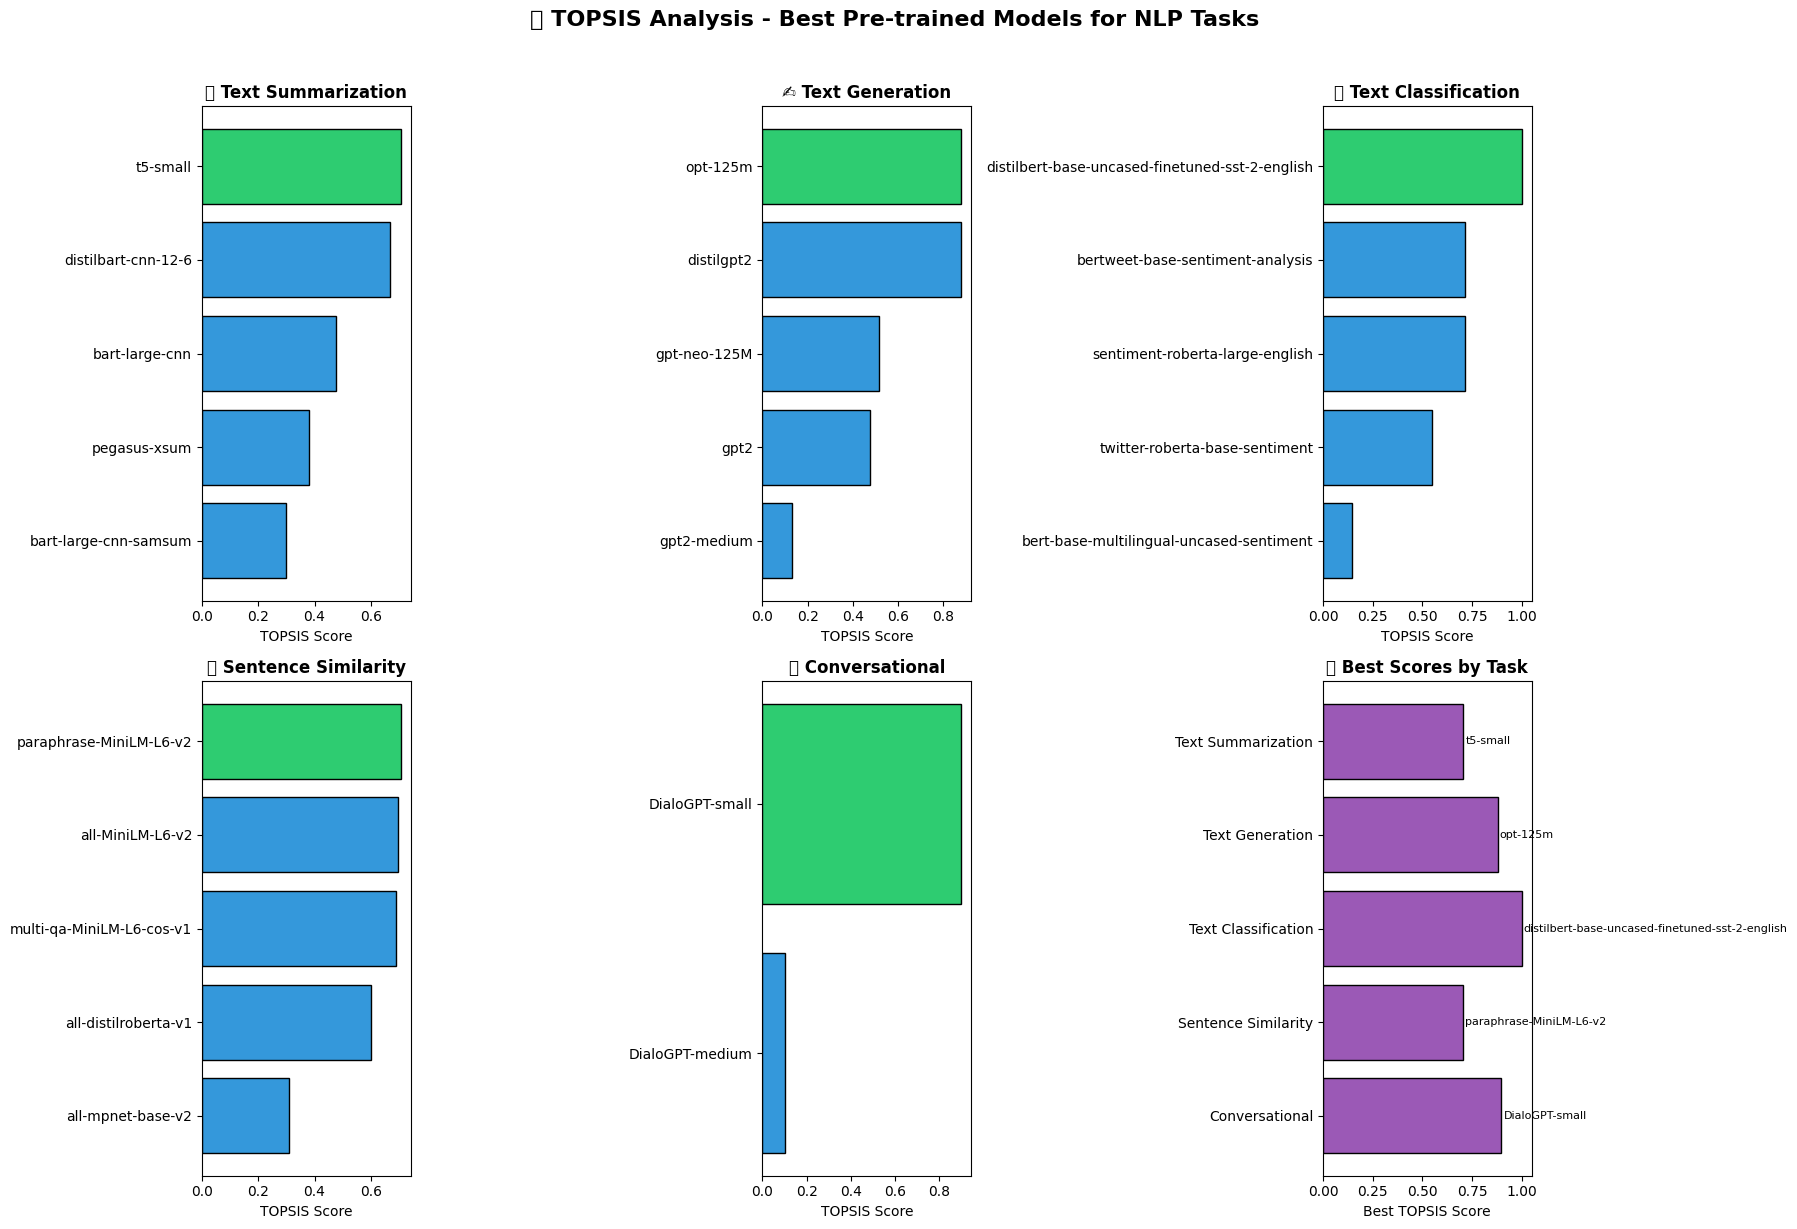


✅ Visualization saved as 'topsis_results.png'


In [9]:
print("\n" + "="*70)
print("📊 FINAL SUMMARY - ALL TASKS")
print("="*70)

# Create summary
summary_data = {
    'Task': ['Text Summarization', 'Text Generation', 'Text Classification',
             'Sentence Similarity', 'Conversational'],
    'Best_Model': [
        df_summarization.iloc[0]['Model'],
        df_generation.iloc[0]['Model'],
        df_classification.iloc[0]['Model'],
        df_similarity.iloc[0]['Model'],
        df_conversational.iloc[0]['Model']
    ],
    'TOPSIS_Score': [
        df_summarization.iloc[0]['TOPSIS_Score'],
        df_generation.iloc[0]['TOPSIS_Score'],
        df_classification.iloc[0]['TOPSIS_Score'],
        df_similarity.iloc[0]['TOPSIS_Score'],
        df_conversational.iloc[0]['TOPSIS_Score']
    ]
}

df_summary = pd.DataFrame(summary_data)
print("\n🏆 BEST MODEL FOR EACH TASK:")
print(df_summary.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Summarization
ax1 = axes[0, 0]
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(df_summarization))]
ax1.barh(df_summarization['Model'], df_summarization['TOPSIS_Score'], color=colors, edgecolor='black')
ax1.set_xlabel('TOPSIS Score')
ax1.set_title('📝 Text Summarization', fontsize=12, fontweight='bold')
ax1.invert_yaxis()

# Plot 2: Generation
ax2 = axes[0, 1]
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(df_generation))]
ax2.barh(df_generation['Model'], df_generation['TOPSIS_Score'], color=colors, edgecolor='black')
ax2.set_xlabel('TOPSIS Score')
ax2.set_title('✍️ Text Generation', fontsize=12, fontweight='bold')
ax2.invert_yaxis()

# Plot 3: Classification
ax3 = axes[0, 2]
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(df_classification))]
ax3.barh(df_classification['Model'], df_classification['TOPSIS_Score'], color=colors, edgecolor='black')
ax3.set_xlabel('TOPSIS Score')
ax3.set_title('🏷️ Text Classification', fontsize=12, fontweight='bold')
ax3.invert_yaxis()

# Plot 4: Similarity
ax4 = axes[1, 0]
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(df_similarity))]
ax4.barh(df_similarity['Model'], df_similarity['TOPSIS_Score'], color=colors, edgecolor='black')
ax4.set_xlabel('TOPSIS Score')
ax4.set_title('🔗 Sentence Similarity', fontsize=12, fontweight='bold')
ax4.invert_yaxis()

# Plot 5: Conversational
ax5 = axes[1, 1]
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(df_conversational))]
ax5.barh(df_conversational['Model'], df_conversational['TOPSIS_Score'], color=colors, edgecolor='black')
ax5.set_xlabel('TOPSIS Score')
ax5.set_title('💬 Conversational', fontsize=12, fontweight='bold')
ax5.invert_yaxis()

# Plot 6: Summary
ax6 = axes[1, 2]
ax6.barh(df_summary['Task'], df_summary['TOPSIS_Score'], color='#9b59b6', edgecolor='black')
ax6.set_xlabel('Best TOPSIS Score')
ax6.set_title('🏆 Best Scores by Task', fontsize=12, fontweight='bold')
ax6.invert_yaxis()

# Add best model labels
for i, (task, model, score) in enumerate(zip(df_summary['Task'], df_summary['Best_Model'], df_summary['TOPSIS_Score'])):
    ax6.text(score + 0.01, i, model, va='center', fontsize=8)

plt.suptitle('📊 TOPSIS Analysis - Best Pre-trained Models for NLP Tasks',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('topsis_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved as 'topsis_results.png'")

In [10]:
from google.colab import files

# Save all results
df_summarization.to_csv('summarization_results.csv', index=False)
df_generation.to_csv('generation_results.csv', index=False)
df_classification.to_csv('classification_results.csv', index=False)
df_similarity.to_csv('similarity_results.csv', index=False)
df_conversational.to_csv('conversational_results.csv', index=False)
df_summary.to_csv('final_summary.csv', index=False)

print("✅ All CSV files saved!")

# Download files
files.download('summarization_results.csv')
files.download('generation_results.csv')
files.download('classification_results.csv')
files.download('similarity_results.csv')
files.download('conversational_results.csv')
files.download('final_summary.csv')
files.download('topsis_results.png')

print("\n📥 All files downloaded!")

✅ All CSV files saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📥 All files downloaded!
